# IMPORTAR BIBLIOTECA PYTHON 

In [135]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import patsy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from fast_ml.feature_engineering import FeatureEngineering_DateTime
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
import catboost as cat
from sklearn.linear_model import LassoCV
from scipy import stats

In [136]:
token_wheter = open('apikey.txt', 'r').read()
user_db = open('user_db.txt', 'r').read()
pass_db = open('pass_db.txt', 'r').read()

In [137]:
def connect_db():
    '''
    This function connect data base
    '''  
   
    import psycopg2
    connection = psycopg2.connect(user=user_db,
                                  password=pass_db,
                                  host="127.0.0.1",
                                  port="5432",
                                  database="postgres",
                                  options="-c search_path=db_atl")


    connection.autocommit = True
    return connection.cursor()

In [138]:
cursor = connect_db()
cursor.execute(f"SELECT  cod_competicao, data_prova_competicao, cod_atleta, latitude, longitude, genero_prova, " \
               f" windspeed, url_atleta, pais_atleta, result, humidity, pressure, temperatura, pais_competicao, cidade_competicao, "\
               f"nome_prova FROM db_atl.v100metros;")
           
list_cod_comp = cursor.fetchall()   
df_provas = pd.DataFrame(list_cod_comp, columns=['cod_competicao',
'data_prova_competicao',
'cod_atleta',
'latitude',
'longitude',
'genero_prova',
'windspeed',
'url_atleta',
'pais_atleta',
'result',
'humidity',
'pressure',
'temperatura',
'pais_competicao',
'cidade_competicao',
'nome_prova'])
df_provas.head()

,cod_competicao,data_prova_competicao,cod_atleta,latitude,longitude,genero_prova,windspeed,url_atleta,pais_atleta,result,humidity,pressure,temperatura,pais_competicao,cidade_competicao,nome_prova
0,565156,2010-07-07,14201990,35.36438,24.47116,Men,25.4,https://worldathletics.org/athletes/jamaica/ma...,jamaica,10.11,53.25,None,27.4,GRE,Rethymno,100 Metres
1,565156,2010-07-07,14249856,35.36438,24.47116,Men,25.4,https://worldathletics.org/athletes/united-sta...,united-states,10.11,53.25,None,27.4,GRE,Rethymno,100 Metres
2,565156,2010-07-07,14202146,35.36438,24.47116,Men,25.4,https://worldathletics.org/athletes/jamaica/st...,jamaica,10.26,53.25,None,27.4,GRE,Rethymno,100 Metres
3,565156,2010-07-07,14190219,35.36438,24.47116,Men,25.4,https://worldathletics.org/athletes/austria/ry...,austria,10.32,53.25,None,27.4,GRE,Rethymno,100 Metres
4,565156,2010-07-07,14174434,35.36438,24.47116,Men,25.4,https://worldathletics.org/athletes/canada/jar...,canada,10.33,53.25,None,27.4,GRE,Rethymno,100 Metres


# LIMPEZA TRATAMENTO DE DADOS 


In [139]:
df_provas['result'] = df_provas['result'].str.replace(r'[a-z]+','')
df_provas['windspeed'] = df_provas['windspeed'].astype('float64')
df_provas['humidity'] = df_provas['humidity'].astype('float64')
df_provas['pressure'] = df_provas['pressure'].astype('float64')
df_provas['temperatura'] = df_provas['temperatura'].astype('float64')
df_provas['result'] = df_provas['result'].astype('float64')

C:\Users\ANDRE~1.NUN\AppData\Local\Temp/ipykernel_73428/3522330149.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_provas['result'] = df_provas['result'].str.replace(r'[a-z]+','')


## TIRANDO UM OUTLIER 

In [140]:
df_provas_clean = df_provas[df_provas['result'] >8]


## LIMPANDO NaN E  FILTRANDO COMPETIÇÃO MASCULINAS

In [141]:
df_provas_clean = df_provas_clean.dropna()

In [142]:
df_provas_clean_man =  df_provas_clean[df_provas_clean['genero_prova'] == 'Men']

## AGRUPAR POR COMPETIÇÃO E OBTER RESULTADO MÉDIO

In [143]:
                              
df_mean =   df_provas_clean_man.groupby('cod_competicao').agg(
    result_mean = pd.NamedAgg('result', 'mean'))                  


In [144]:
df_provas_clean_man = df_provas_clean_man.merge(df_mean, on = 'cod_competicao')

In [145]:
df_provas_clean_man = df_provas_clean_man.groupby('cod_competicao').first()

## TRATAR DATA DA PROVA

In [146]:
df_provas_clean_man['data_prova_competicao'] = df_provas_clean_man['data_prova_competicao'].astype('datetime64')
date_fet = FeatureEngineering_DateTime()
date_fet.fit(df_provas_clean_man, datetime_variables=['data_prova_competicao'])
df_provas_clean_man = date_fet.transform(df_provas_clean_man)

dict_rename = {column : column.lower().rstrip().lstrip().replace(' ', '_').replace('.', '_').replace(':', '_') for column in df_provas_clean_man}
df_provas_clean_man = df_provas_clean_man.rename(dict_rename, axis = 1)


C:\Users\andre.nunes\Anaconda3\lib\site-packages\fast_ml\feature_engineering.py:382: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[pfx+f] = getattr(df[var].dt, f)


In [147]:
df_provas_clean_man = df_provas_clean_man.drop("data_prova_competicao_day_part", axis=1)


# ANÁLISE EXPLORATÓRIA DOS DADOS 

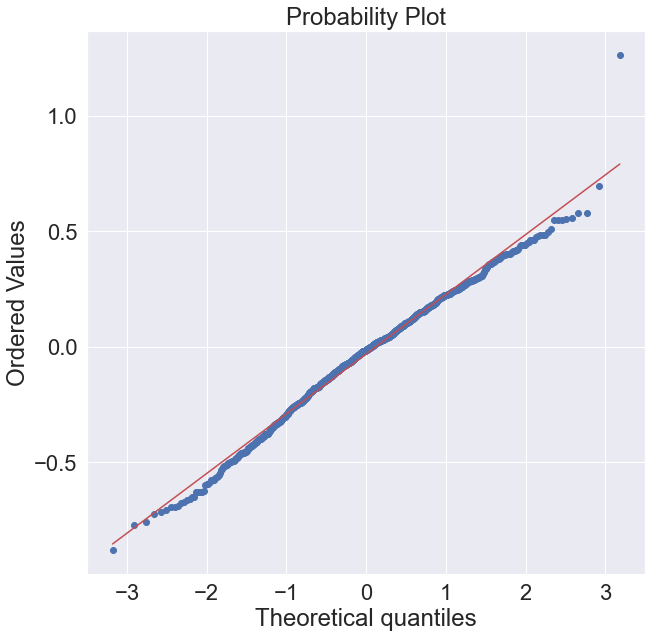

In [148]:
from scipy import stats
plt.figure(figsize=(10,10))
stats.probplot(teste_hist['result_mean'], plot=plt)
plt.show()

In [149]:
df_provas_clean_man.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6157 entries, 482442 to 608509
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   data_prova_competicao                   6157 non-null   datetime64[ns]
 1   cod_atleta                              6157 non-null   int64         
 2   latitude                                6157 non-null   float64       
 3   longitude                               6157 non-null   float64       
 4   genero_prova                            6157 non-null   object        
 5   windspeed                               6157 non-null   float64       
 6   url_atleta                              6157 non-null   object        
 7   pais_atleta                             6157 non-null   object        
 8   result                                  6157 non-null   float64       
 9   humidity                                6157 

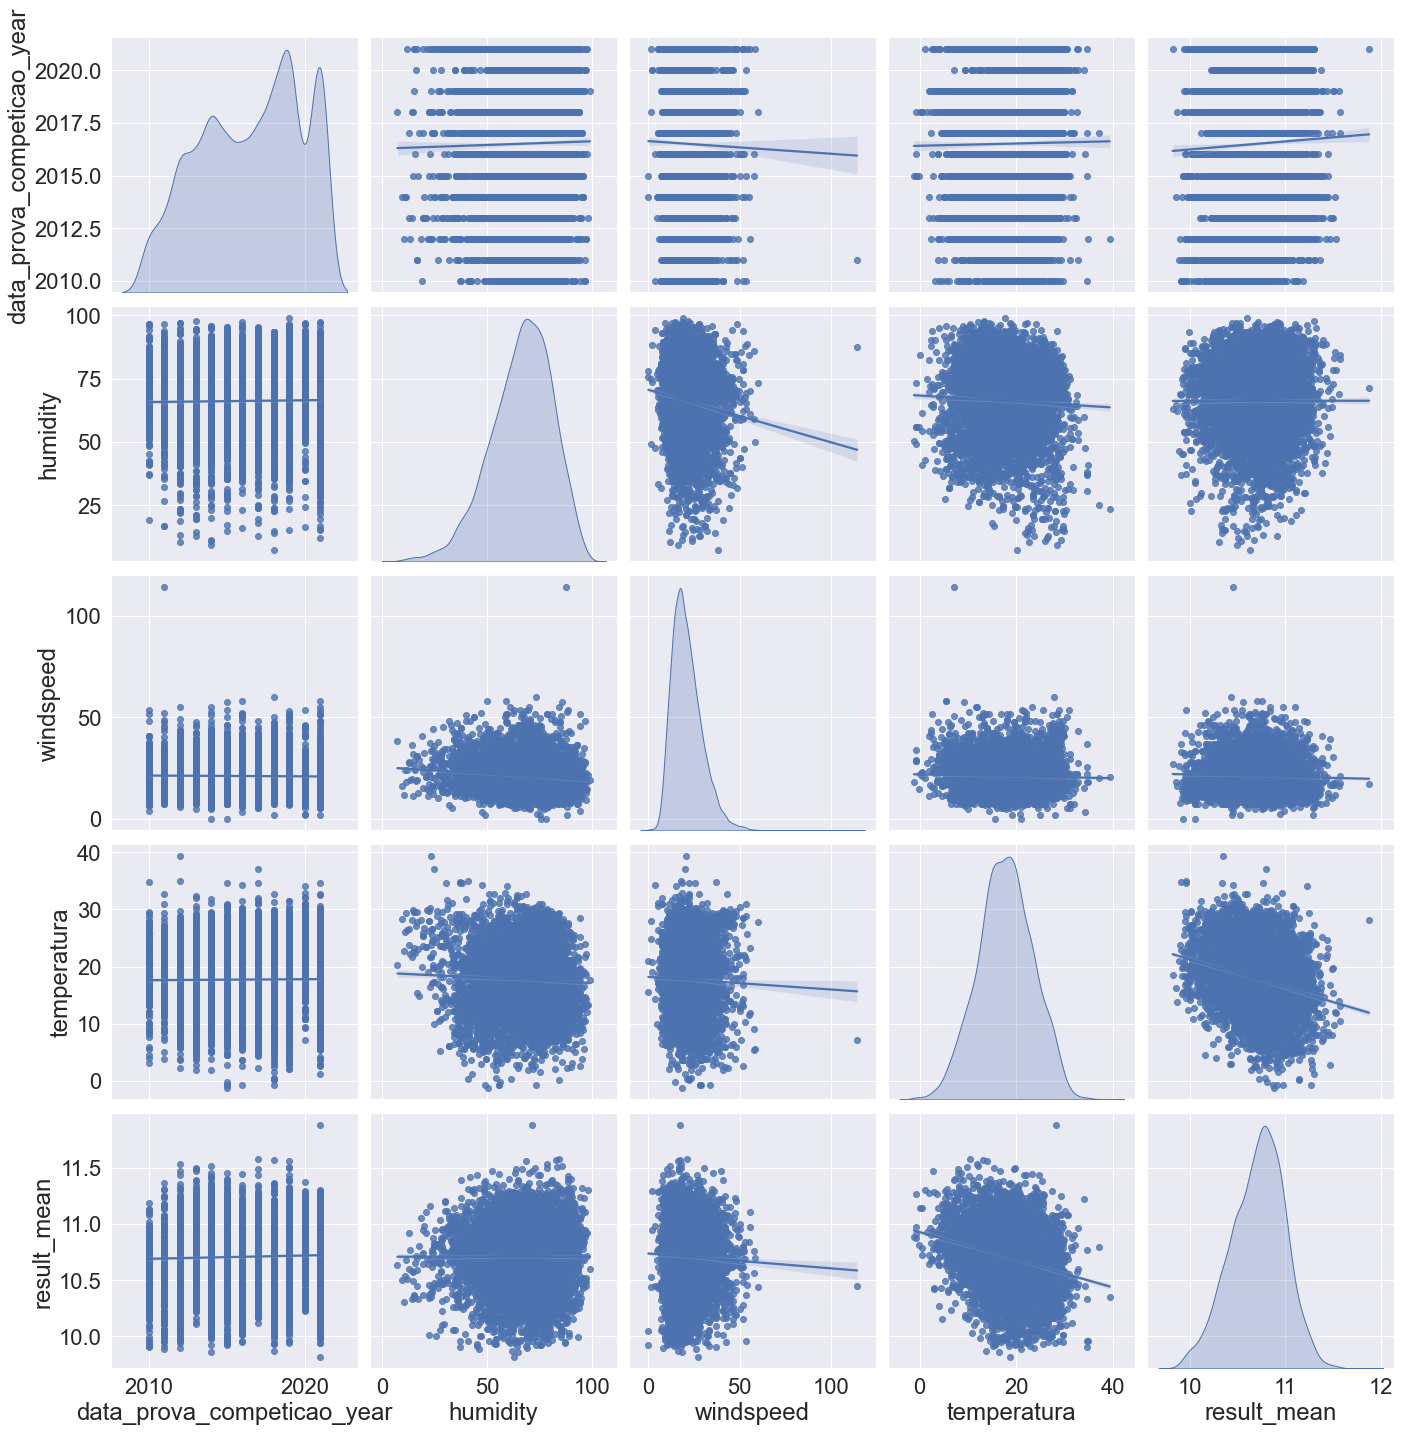

In [150]:
sns.pairplot(data = df_provas_clean_man.reset_index()[["data_prova_competicao_year","humidity", "windspeed", "temperatura", "result_mean"]], diag_kind = 'kde', kind = 'reg', height = 4)

In [151]:
Var = ["latitude", "longitude", "humidity", "pressure", "temperatura", "windspeed"]
X = sm.add_constant(df_provas_clean_man[Var])
Y = df_provas_clean_man['result_mean']
modelo = sm.OLS(Y, X)
lm_fit = modelo.fit()
lm_fit.summary()

C:\Users\andre.nunes\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            result_mean   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     86.98
Date:                Fri, 06 May 2022   Prob (F-statistic):          4.99e-105
Time:                        13:06:13   Log-Likelihood:                -698.27
No. Observations:                6157   AIC:                             1411.
Df Residuals:                    6150   BIC:                             1458.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.0638      0.673     17.938      0.000      10.745      13.382
latitude    -9.347e-05      0.000     -0.487      0.626      -0.000       0.000
longitude       0.0005   5.07e-05      9.377      0.000       0.000       0.001
humidity       -0.0009      0.000     -3.712      0.000      -0.001      -0.000
pressure       -0.0010      0.001     -1.483      0.138      -0.002       0.000
temperatura    -0.0145      0.001    -21.374      0.000      -0.016      -0.013
windspeed      -0.0017      0.000     -3.799      0.000      -0.003      -0.001
==============================================================================
Omnibus:                       46.905   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.891
Skew:                          -0.215   Prob(JB):                     3.99e-11
Kurtosis:                       2.966   Cond. No.                     1.98e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As variaveis indepedentes climáticas com maior relevância estatistica entre as climáticas são a temperatura, humidade e velocidade do vento. Usaremos elas em nossos estudos daqui em diante. Entendo que as demais não fazem sentido. A temperatura aparenta ter uma maior relação INVERSA, para cada  um grau centigrado, o tempo baixa 0,0145, seguido da velocidade do vento e da humidade em representatividade. 

# SEPARAR DADOS EM TRAIN E TEST (SEPARAR ANO de 2021 PARA PREVISÃO)

In [152]:
df_train = df_provas_clean_man[df_provas_clean_man["data_prova_competicao_year"] < 2021] 
df_test = df_provas_clean_man[df_provas_clean_man["data_prova_competicao_year"] >= 2021] 


decidi usar os anos anteriores para treinar e 2021 como teste do modelo 

In [153]:
Var = ["humidity",  "temperatura", "windspeed"]
X_train = df_train[["humidity",  "temperatura", "windspeed"]]
y_train = df_train['result_mean']

X_test = df_test[["humidity",  "temperatura", "windspeed"]]
y_test = df_test['result_mean']


# PRIMEIRA REGRESSÃO LINEAR

In [154]:
from sklearn.metrics import mean_squared_error
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))

modelo = LinearRegression()
modelo.fit(X_train, y_train)


pd.DataFrame(modelo.coef_, index = Var)

,0
humidity,-0.007153
temperatura,-0.073886
windspeed,-0.013106


## RELAÇÃO ENTRE OS COEFICIENTES

[Text(0.5, 1.0, 'Relação entre os coeficientes da regressão')]

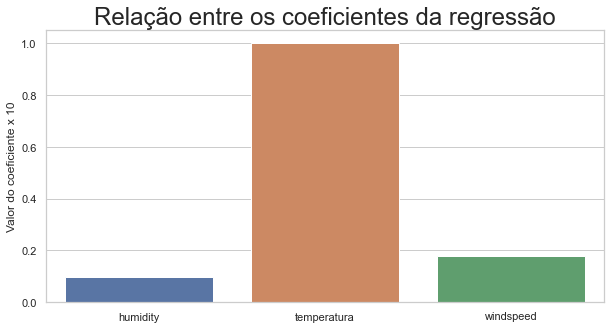

In [155]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 2)
ax.set(ylabel="Valor do coeficiente x 10")
sns.barplot(x = Var, y = modelo.coef_/min(modelo.coef_)).set(title='Relação entre os coeficientes da regressão')


In [156]:
np.std(y_train)

0.285442040211297

In [157]:
pred_reg = modelo.predict(scaler.transform(X_test))
print(f"RMSE DA REGRESSÃO LINEAR: {np.sqrt(mean_squared_error(y_test, pred_reg))}")


RMSE DA REGRESSÃO LINEAR: 0.2598665052329975


## OS RESULTADOS É UMA DISTRIBUIÇÃO NORMAL

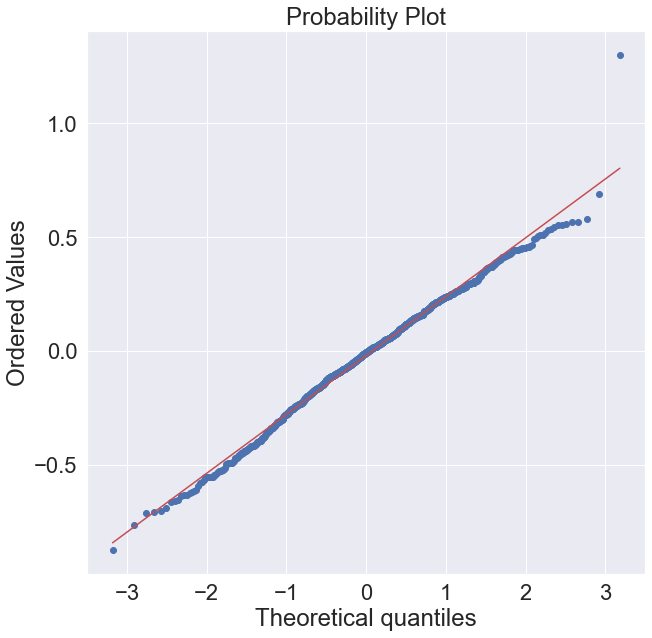

In [159]:
teste_hist = pd.DataFrame(y_test - pred_reg)
from scipy import stats
plt.figure(figsize=(10,10))
plt.title("Gráfico de Probabilidades")
stats.probplot(teste_hist['result_mean'], plot=plt)
plt.show()

# EXPERIMENTADO O LASSO

In [160]:
las_fit = LassoCV(cv=5)
las_fit.fit(X_train, y_train)

LassoCV(cv=5)

In [161]:
pred_reg = las_fit.predict(scaler.transform(X_test))
print(f"RMSE DO LASSO: {np.sqrt(mean_squared_error(y_test, pred_reg))}")

RMSE DO LASSO: 0.2598561405964923


# USO DA CATBOOST

In [162]:
Os melhores parametros encontrados no gridsearch foram os usados no comando abaixo

SyntaxError: invalid syntax (Temp/ipykernel_73428/1900558376.py, line 1)

In [163]:
'''param_grid = {
    'iterations' : [18000, 20000, 22000],
    'depth' : [5,7,8,10],
     'od_wait' : [500]
    
}

cat_fit = cat.CatBoostRegressor()
cat_fit = GridSearchCV(cat_fit, param_grid)'''

cat_fit = cat.CatBoostRegressor(iterations = 20000, depth = 8, od_type = "Iter", od_wait = 500)
cat_fit.fit(X_train, y_train, eval_set = (scaler.transform(X_test), y_test))





Learning rate set to 0.010612
0:	learn: 0.2852123	test: 0.2642519	best: 0.2642519 (0)	total: 4.41ms	remaining: 1m 28s
1:	learn: 0.2849864	test: 0.2641292	best: 0.2641292 (1)	total: 8ms	remaining: 1m 19s
2:	learn: 0.2847642	test: 0.2640130	best: 0.2640130 (2)	total: 11.4ms	remaining: 1m 15s
3:	learn: 0.2845476	test: 0.2638998	best: 0.2638998 (3)	total: 14.9ms	remaining: 1m 14s
4:	learn: 0.2843412	test: 0.2637540	best: 0.2637540 (4)	total: 18.4ms	remaining: 1m 13s
5:	learn: 0.2841138	test: 0.2636321	best: 0.2636321 (5)	total: 22.1ms	remaining: 1m 13s
6:	learn: 0.2839154	test: 0.2634966	best: 0.2634966 (6)	total: 25.9ms	remaining: 1m 13s
7:	learn: 0.2837098	test: 0.2633707	best: 0.2633707 (7)	total: 29.7ms	remaining: 1m 14s
8:	learn: 0.2835032	test: 0.2632507	best: 0.2632507 (8)	total: 33ms	remaining: 1m 13s
9:	learn: 0.2833161	test: 0.2631293	best: 0.2631293 (9)	total: 36ms	remaining: 1m 12s
10:	learn: 0.2831254	test: 0.2630199	best: 0.2630199 (10)	total: 39.2ms	remaining: 1m 11s
11:	lea

112:	learn: 0.2733537	test: 0.2595968	best: 0.2595745 (106)	total: 344ms	remaining: 1m
113:	learn: 0.2733042	test: 0.2595834	best: 0.2595745 (106)	total: 347ms	remaining: 1m
114:	learn: 0.2732634	test: 0.2595797	best: 0.2595745 (106)	total: 351ms	remaining: 1m
115:	learn: 0.2732167	test: 0.2595815	best: 0.2595745 (106)	total: 354ms	remaining: 1m
116:	learn: 0.2731799	test: 0.2595754	best: 0.2595745 (106)	total: 358ms	remaining: 1m
117:	learn: 0.2731308	test: 0.2595577	best: 0.2595577 (117)	total: 361ms	remaining: 1m
118:	learn: 0.2731002	test: 0.2595456	best: 0.2595456 (118)	total: 365ms	remaining: 1m
119:	learn: 0.2730579	test: 0.2595354	best: 0.2595354 (119)	total: 368ms	remaining: 1m
120:	learn: 0.2730240	test: 0.2595288	best: 0.2595288 (120)	total: 371ms	remaining: 1m
121:	learn: 0.2729841	test: 0.2595408	best: 0.2595288 (120)	total: 374ms	remaining: 1m
122:	learn: 0.2729418	test: 0.2595469	best: 0.2595288 (120)	total: 377ms	remaining: 1m
123:	learn: 0.2728954	test: 0.2595442	best:

223:	learn: 0.2700530	test: 0.2599194	best: 0.2595189 (130)	total: 693ms	remaining: 1m 1s
224:	learn: 0.2700387	test: 0.2599193	best: 0.2595189 (130)	total: 696ms	remaining: 1m 1s
225:	learn: 0.2700210	test: 0.2599206	best: 0.2595189 (130)	total: 699ms	remaining: 1m 1s
226:	learn: 0.2700005	test: 0.2599243	best: 0.2595189 (130)	total: 703ms	remaining: 1m 1s
227:	learn: 0.2699752	test: 0.2599243	best: 0.2595189 (130)	total: 706ms	remaining: 1m 1s
228:	learn: 0.2699556	test: 0.2599349	best: 0.2595189 (130)	total: 709ms	remaining: 1m 1s
229:	learn: 0.2699357	test: 0.2599505	best: 0.2595189 (130)	total: 712ms	remaining: 1m 1s
230:	learn: 0.2699163	test: 0.2599585	best: 0.2595189 (130)	total: 715ms	remaining: 1m 1s
231:	learn: 0.2698987	test: 0.2599569	best: 0.2595189 (130)	total: 718ms	remaining: 1m 1s
232:	learn: 0.2698737	test: 0.2599560	best: 0.2595189 (130)	total: 721ms	remaining: 1m 1s
233:	learn: 0.2698535	test: 0.2599634	best: 0.2595189 (130)	total: 724ms	remaining: 1m 1s
234:	learn

338:	learn: 0.2679530	test: 0.2603180	best: 0.2595189 (130)	total: 1.04s	remaining: 1m
339:	learn: 0.2679393	test: 0.2603184	best: 0.2595189 (130)	total: 1.04s	remaining: 1m
340:	learn: 0.2679232	test: 0.2603223	best: 0.2595189 (130)	total: 1.05s	remaining: 1m
341:	learn: 0.2679030	test: 0.2603207	best: 0.2595189 (130)	total: 1.05s	remaining: 1m
342:	learn: 0.2678867	test: 0.2603320	best: 0.2595189 (130)	total: 1.05s	remaining: 1m
343:	learn: 0.2678750	test: 0.2603286	best: 0.2595189 (130)	total: 1.06s	remaining: 1m
344:	learn: 0.2678579	test: 0.2603273	best: 0.2595189 (130)	total: 1.06s	remaining: 1m
345:	learn: 0.2678377	test: 0.2603283	best: 0.2595189 (130)	total: 1.06s	remaining: 1m
346:	learn: 0.2678286	test: 0.2603331	best: 0.2595189 (130)	total: 1.07s	remaining: 1m
347:	learn: 0.2678110	test: 0.2603376	best: 0.2595189 (130)	total: 1.07s	remaining: 1m
348:	learn: 0.2677926	test: 0.2603494	best: 0.2595189 (130)	total: 1.07s	remaining: 1m
349:	learn: 0.2677815	test: 0.2603550	best:

454:	learn: 0.2661172	test: 0.2607662	best: 0.2595189 (130)	total: 1.39s	remaining: 59.7s
455:	learn: 0.2661074	test: 0.2607628	best: 0.2595189 (130)	total: 1.39s	remaining: 59.7s
456:	learn: 0.2660964	test: 0.2607606	best: 0.2595189 (130)	total: 1.4s	remaining: 59.8s
457:	learn: 0.2660738	test: 0.2607708	best: 0.2595189 (130)	total: 1.4s	remaining: 59.8s
458:	learn: 0.2660623	test: 0.2607700	best: 0.2595189 (130)	total: 1.4s	remaining: 59.8s
459:	learn: 0.2660425	test: 0.2607739	best: 0.2595189 (130)	total: 1.41s	remaining: 59.8s
460:	learn: 0.2660277	test: 0.2607691	best: 0.2595189 (130)	total: 1.41s	remaining: 59.8s
461:	learn: 0.2660157	test: 0.2607574	best: 0.2595189 (130)	total: 1.41s	remaining: 59.8s
462:	learn: 0.2660028	test: 0.2607579	best: 0.2595189 (130)	total: 1.42s	remaining: 59.7s
463:	learn: 0.2659953	test: 0.2607546	best: 0.2595189 (130)	total: 1.42s	remaining: 59.7s
464:	learn: 0.2659807	test: 0.2607542	best: 0.2595189 (130)	total: 1.42s	remaining: 59.7s
465:	learn: 0

568:	learn: 0.2644984	test: 0.2610105	best: 0.2595189 (130)	total: 1.74s	remaining: 59.3s
569:	learn: 0.2644908	test: 0.2610103	best: 0.2595189 (130)	total: 1.74s	remaining: 59.3s
570:	learn: 0.2644826	test: 0.2610169	best: 0.2595189 (130)	total: 1.74s	remaining: 59.3s
571:	learn: 0.2644688	test: 0.2610102	best: 0.2595189 (130)	total: 1.75s	remaining: 59.3s
572:	learn: 0.2644569	test: 0.2610117	best: 0.2595189 (130)	total: 1.75s	remaining: 59.3s
573:	learn: 0.2644464	test: 0.2610149	best: 0.2595189 (130)	total: 1.75s	remaining: 59.3s
574:	learn: 0.2644321	test: 0.2610197	best: 0.2595189 (130)	total: 1.75s	remaining: 59.3s
575:	learn: 0.2644231	test: 0.2610190	best: 0.2595189 (130)	total: 1.76s	remaining: 59.3s
576:	learn: 0.2644109	test: 0.2610247	best: 0.2595189 (130)	total: 1.76s	remaining: 59.3s
577:	learn: 0.2643948	test: 0.2610256	best: 0.2595189 (130)	total: 1.76s	remaining: 59.3s
578:	learn: 0.2643851	test: 0.2610231	best: 0.2595189 (130)	total: 1.77s	remaining: 59.3s
579:	learn

In [164]:
pred_reg = cat_fit.predict(scaler.transform(X_test))
print(f"RMSE DO CATBOOST: {np.sqrt(mean_squared_error(y_test, pred_reg))}")

RMSE DO CATBOOST: 0.25951886709571664


[Text(0.5, 0, 'Resultados Médios')]

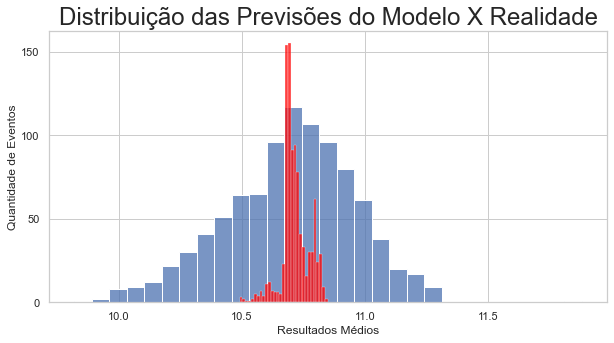

In [165]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 2)
sns.histplot(y_test)
sns.histplot(pred_reg, color='red').set(title='Distribuição das Previsões do Modelo X Realidade')
ax.set(ylabel="Quantidade de Eventos")
ax.set(xlabel="Resultados Médios")





In [166]:
np.std(pred_reg)

0.05578173794242168

In [167]:
np.std(y_test)

0.26382847159892475

In [168]:
np.std(y_test)-np.std(pred_reg)

0.20804673365650306

In [169]:
np.std(y_test) - (np.std(y_test)-np.std(pred_reg))

0.055781737942421694

In [99]:
print (f'A previsão do modelo é igual a {(np.std(y_test) - (np.std(y_test) - np.std(pred_reg))) * 10} décimos')

A previsão do modelo é igual a 0.5494163667606361 décimos


# SIMULANDO CONDIÇÕES CLIMÁTICAS 

In [115]:
temp_max = df_provas_clean_man['temperatura'].max()
temp_min = df_provas_clean_man['temperatura'].min()

humd_max = df_provas_clean_man['humidity'].max()
humd_min = df_provas_clean_man['humidity'].min()

wind_max = df_provas_clean_man['windspeed'].max()
wind_min = df_provas_clean_man['windspeed'].min()

dict = {'temperatura': np.linspace(temp_min * 0.9, temp_max *1.1, num=100),
        'humidity' : df_provas_clean_man['humidity'].mean(), 
        'windspeed' : df_provas_clean_man['windspeed'].mean() }
df_temp = pd.DataFrame(data=dict)
df_temp['temp2'] = df_temp['temperatura'] ** 2
df_temp['hum2'] = df_temp['humidity'] ** 2
df_temp['win2'] = df_temp['windspeed'] ** 2

dict = {'temperatura': df_provas_clean_man['temperatura'].mean(),
        'humidity' : np.linspace(humd_min * 0.9, humd_max, num=100), 
        'windspeed' : df_provas_clean_man['windspeed'].mean() }
df_hum = pd.DataFrame(data=dict)
df_hum['hum2'] = df_hum['humidity'] ** 2
df_hum['temp2'] = df_hum['temperatura'] ** 2
df_hum['win2'] = df_hum['windspeed'] ** 2

dict = {'temperatura': df_provas_clean_man['temperatura'].mean(),
        'humidity' : df_provas_clean_man['humidity'].mean() , 
        'windspeed' : np.linspace(wind_min * 0.9, wind_max *1.1, num=100) }
df_win = pd.DataFrame(data=dict)
df_win['win2'] = df_win['windspeed'] ** 2
df_win['hum2'] = df_win['humidity'] ** 2
df_win['temp2'] = df_win['temperatura'] ** 2



In [116]:
Var = ["humidity","hum2",  "temperatura", "temp2", "windspeed", "win2"]
df_train['temp2'] = df_train['temperatura'] ** 2
df_train['hum2'] = df_train['humidity'] ** 2
df_train['win2'] = df_train['windspeed'] ** 2
X_train = df_train[Var]
y_train = df_train['result_mean']

df_test['temp2'] = df_test['temperatura'] ** 2
df_test['hum2'] = df_test['humidity'] ** 2
df_test['win2'] = df_test['windspeed'] ** 2
X_test = df_test[Var]
y_test = df_test['result_mean']

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))

C:\Users\ANDRE~1.NUN\AppData\Local\Temp/ipykernel_73428/4223897692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['temp2'] = df_train['temperatura'] ** 2
C:\Users\ANDRE~1.NUN\AppData\Local\Temp/ipykernel_73428/4223897692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['hum2'] = df_train['humidity'] ** 2
C:\Users\ANDRE~1.NUN\AppData\Local\Temp/ipykernel_73428/4223897692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [117]:
cat_fit = cat.CatBoostRegressor(iterations = 20000, depth = 8, od_type = "Iter", od_wait = 500)
cat_fit.fit(X_train, y_train, eval_set = (scaler.transform(X_test), y_test))




Learning rate set to 0.010492
0:	learn: 0.2818081	test: 0.2653810	best: 0.2653810 (0)	total: 5.51ms	remaining: 1m 50s
1:	learn: 0.2815817	test: 0.2652471	best: 0.2652471 (1)	total: 9.22ms	remaining: 1m 32s
2:	learn: 0.2813525	test: 0.2650988	best: 0.2650988 (2)	total: 12.9ms	remaining: 1m 25s
3:	learn: 0.2811441	test: 0.2650068	best: 0.2650068 (3)	total: 19ms	remaining: 1m 35s
4:	learn: 0.2809301	test: 0.2648787	best: 0.2648787 (4)	total: 23.8ms	remaining: 1m 35s
5:	learn: 0.2807191	test: 0.2647636	best: 0.2647636 (5)	total: 28.5ms	remaining: 1m 34s
6:	learn: 0.2805015	test: 0.2646482	best: 0.2646482 (6)	total: 33.7ms	remaining: 1m 36s
7:	learn: 0.2803137	test: 0.2645157	best: 0.2645157 (7)	total: 38.8ms	remaining: 1m 36s
8:	learn: 0.2801155	test: 0.2643801	best: 0.2643801 (8)	total: 43.7ms	remaining: 1m 37s
9:	learn: 0.2799327	test: 0.2642827	best: 0.2642827 (9)	total: 47.2ms	remaining: 1m 34s
10:	learn: 0.2797303	test: 0.2641959	best: 0.2641959 (10)	total: 52.3ms	remaining: 1m 35s
11

95:	learn: 0.2705512	test: 0.2608527	best: 0.2608527 (95)	total: 365ms	remaining: 1m 15s
96:	learn: 0.2704866	test: 0.2608371	best: 0.2608371 (96)	total: 369ms	remaining: 1m 15s
97:	learn: 0.2704297	test: 0.2608395	best: 0.2608371 (96)	total: 372ms	remaining: 1m 15s
98:	learn: 0.2703683	test: 0.2608464	best: 0.2608371 (96)	total: 376ms	remaining: 1m 15s
99:	learn: 0.2703274	test: 0.2608420	best: 0.2608371 (96)	total: 379ms	remaining: 1m 15s
100:	learn: 0.2702721	test: 0.2608422	best: 0.2608371 (96)	total: 383ms	remaining: 1m 15s
101:	learn: 0.2702133	test: 0.2608383	best: 0.2608371 (96)	total: 387ms	remaining: 1m 15s
102:	learn: 0.2701636	test: 0.2608422	best: 0.2608371 (96)	total: 390ms	remaining: 1m 15s
103:	learn: 0.2701162	test: 0.2608263	best: 0.2608263 (103)	total: 394ms	remaining: 1m 15s
104:	learn: 0.2700671	test: 0.2608263	best: 0.2608263 (103)	total: 398ms	remaining: 1m 15s
105:	learn: 0.2700218	test: 0.2608252	best: 0.2608252 (105)	total: 401ms	remaining: 1m 15s
106:	learn: 

231:	learn: 0.2658555	test: 0.2613621	best: 0.2608059 (110)	total: 881ms	remaining: 1m 15s
232:	learn: 0.2658407	test: 0.2613694	best: 0.2608059 (110)	total: 884ms	remaining: 1m 14s
233:	learn: 0.2658216	test: 0.2613801	best: 0.2608059 (110)	total: 888ms	remaining: 1m 14s
234:	learn: 0.2657977	test: 0.2613704	best: 0.2608059 (110)	total: 891ms	remaining: 1m 14s
235:	learn: 0.2657721	test: 0.2613870	best: 0.2608059 (110)	total: 896ms	remaining: 1m 14s
236:	learn: 0.2657460	test: 0.2613853	best: 0.2608059 (110)	total: 899ms	remaining: 1m 14s
237:	learn: 0.2657207	test: 0.2613715	best: 0.2608059 (110)	total: 903ms	remaining: 1m 14s
238:	learn: 0.2656936	test: 0.2613683	best: 0.2608059 (110)	total: 906ms	remaining: 1m 14s
239:	learn: 0.2656724	test: 0.2613722	best: 0.2608059 (110)	total: 909ms	remaining: 1m 14s
240:	learn: 0.2656522	test: 0.2613767	best: 0.2608059 (110)	total: 912ms	remaining: 1m 14s
241:	learn: 0.2656388	test: 0.2613606	best: 0.2608059 (110)	total: 915ms	remaining: 1m 14s

330:	learn: 0.2638197	test: 0.2618725	best: 0.2608059 (110)	total: 1.23s	remaining: 1m 12s
331:	learn: 0.2638063	test: 0.2618806	best: 0.2608059 (110)	total: 1.23s	remaining: 1m 12s
332:	learn: 0.2637864	test: 0.2618768	best: 0.2608059 (110)	total: 1.24s	remaining: 1m 12s
333:	learn: 0.2637623	test: 0.2618962	best: 0.2608059 (110)	total: 1.24s	remaining: 1m 12s
334:	learn: 0.2637492	test: 0.2618977	best: 0.2608059 (110)	total: 1.24s	remaining: 1m 12s
335:	learn: 0.2637318	test: 0.2618936	best: 0.2608059 (110)	total: 1.25s	remaining: 1m 12s
336:	learn: 0.2637211	test: 0.2618898	best: 0.2608059 (110)	total: 1.25s	remaining: 1m 12s
337:	learn: 0.2637099	test: 0.2618915	best: 0.2608059 (110)	total: 1.25s	remaining: 1m 12s
338:	learn: 0.2636865	test: 0.2619067	best: 0.2608059 (110)	total: 1.26s	remaining: 1m 12s
339:	learn: 0.2636724	test: 0.2619126	best: 0.2608059 (110)	total: 1.26s	remaining: 1m 12s
340:	learn: 0.2636548	test: 0.2619058	best: 0.2608059 (110)	total: 1.26s	remaining: 1m 12s

431:	learn: 0.2620110	test: 0.2622584	best: 0.2608059 (110)	total: 1.57s	remaining: 1m 11s
432:	learn: 0.2619847	test: 0.2622614	best: 0.2608059 (110)	total: 1.58s	remaining: 1m 11s
433:	learn: 0.2619724	test: 0.2622675	best: 0.2608059 (110)	total: 1.58s	remaining: 1m 11s
434:	learn: 0.2619539	test: 0.2622674	best: 0.2608059 (110)	total: 1.59s	remaining: 1m 11s
435:	learn: 0.2619313	test: 0.2622646	best: 0.2608059 (110)	total: 1.59s	remaining: 1m 11s
436:	learn: 0.2619224	test: 0.2622647	best: 0.2608059 (110)	total: 1.59s	remaining: 1m 11s
437:	learn: 0.2619067	test: 0.2622827	best: 0.2608059 (110)	total: 1.6s	remaining: 1m 11s
438:	learn: 0.2618832	test: 0.2622815	best: 0.2608059 (110)	total: 1.6s	remaining: 1m 11s
439:	learn: 0.2618616	test: 0.2622678	best: 0.2608059 (110)	total: 1.6s	remaining: 1m 11s
440:	learn: 0.2618428	test: 0.2622600	best: 0.2608059 (110)	total: 1.61s	remaining: 1m 11s
441:	learn: 0.2618310	test: 0.2622562	best: 0.2608059 (110)	total: 1.61s	remaining: 1m 11s
44

531:	learn: 0.2603916	test: 0.2624282	best: 0.2608059 (110)	total: 1.92s	remaining: 1m 10s
532:	learn: 0.2603762	test: 0.2624361	best: 0.2608059 (110)	total: 1.92s	remaining: 1m 10s
533:	learn: 0.2603635	test: 0.2624475	best: 0.2608059 (110)	total: 1.93s	remaining: 1m 10s
534:	learn: 0.2603495	test: 0.2624511	best: 0.2608059 (110)	total: 1.93s	remaining: 1m 10s
535:	learn: 0.2603324	test: 0.2624569	best: 0.2608059 (110)	total: 1.93s	remaining: 1m 10s
536:	learn: 0.2603171	test: 0.2624598	best: 0.2608059 (110)	total: 1.94s	remaining: 1m 10s
537:	learn: 0.2603084	test: 0.2624634	best: 0.2608059 (110)	total: 1.94s	remaining: 1m 10s
538:	learn: 0.2602894	test: 0.2624661	best: 0.2608059 (110)	total: 1.95s	remaining: 1m 10s
539:	learn: 0.2602776	test: 0.2624724	best: 0.2608059 (110)	total: 1.95s	remaining: 1m 10s
540:	learn: 0.2602561	test: 0.2624690	best: 0.2608059 (110)	total: 1.96s	remaining: 1m 10s
541:	learn: 0.2602422	test: 0.2624780	best: 0.2608059 (110)	total: 1.96s	remaining: 1m 10s

In [118]:
reg_fit = LinearRegression()
reg_fit.fit(X_train, y_train)

LinearRegression()

In [119]:
df_temp['result_cat'] = cat_fit.predict(scaler.transform(df_temp[Var]))
df_temp['result_reg'] = reg_fit.predict(scaler.transform(df_temp[Var]))

## VARIANDO TEMPERATURA

<AxesSubplot:title={'center':'Simulação da Variação da Temperatura'}, xlabel='temperatura', ylabel='Resultado'>

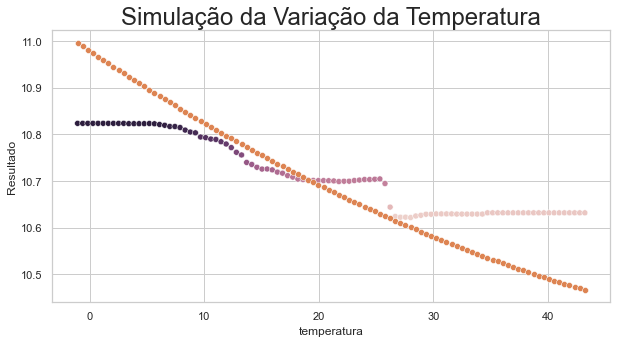

In [134]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 2)
ax.set(ylabel="Resultado")


sns.scatterplot(data=df_temp, x='temperatura', y='result_cat', hue='result_cat', legend = False).set(title='Simulação da Variação da Temperatura')
sns.scatterplot(data=df_temp, x='temperatura', y='result_reg')

De acordo com modelo CATBOOST, os melhores resultado estão entre 15 e 25 graus, a regressão linear diz pouco a esse respeito, ainda é possível notar que temperaturas mais baixas que 10 graus e maiores que 25 podem não ter muitos pontos no conjunto de treinamento. 

[Text(0.5, 1.0, 'Distribuição da Temperatura')]

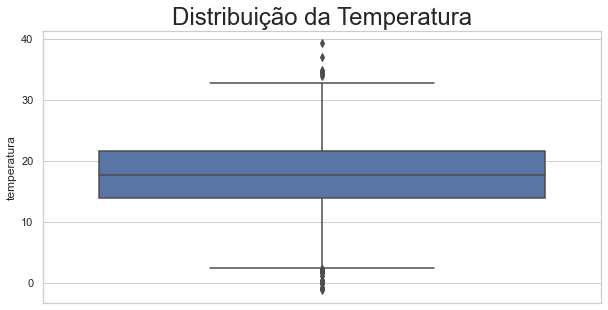

In [122]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 2)
ax.set(ylabel="Resultado")

sns.boxplot(data=df_provas_clean_man, y='temperatura').set(title='Distribuição da Temperatura')


In [ ]:
Como observado 50% dos dados estão na região em que o modelo fez previsões

# SIMULANDO  A HUMIDADE

<AxesSubplot:title={'center':'Simulação da Variação da Humidade'}, xlabel='humidity', ylabel='Resultado'>

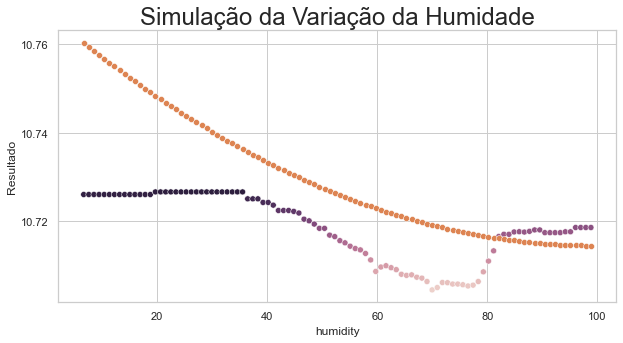

In [133]:
df_hum['result_cat'] = cat_fit.predict(scaler.transform(df_hum[Var]))
df_hum['result_reg'] = reg_fit.predict(scaler.transform(df_hum[Var]))


sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 2)
ax.set(ylabel="Resultado")

sns.scatterplot(data=df_hum, x='humidity', y='result_cat', hue='result_cat', legend = False).set(title='Simulação da Variação da Humidade')
sns.scatterplot(data=df_hum, x='humidity', y='result_reg')



O modelo de regressão e catboost consideram que quanto maior a humidade melhor o resultado, mas no catboost existe uma região com os melhores resultados, entre 60% e 80% de humidade. Parece que não existem muitos dados com humidade inferior a 40% e superior a 80%, lembrando que o patamar superior é 100% :)

[Text(0.5, 1.0, 'Distribuição da Humidade')]

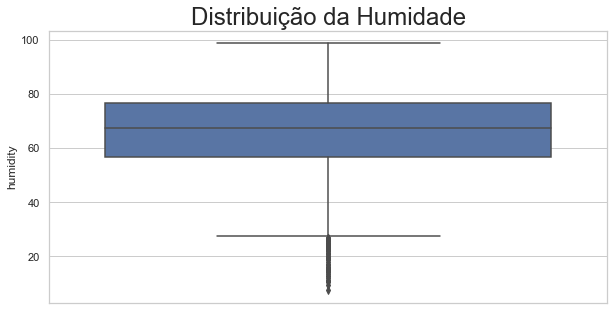

In [124]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 2)
ax.set(ylabel="Resultado")


sns.boxplot(data=df_provas_clean_man, y='humidity').set(title='Distribuição da Humidade')

50% dos dados estão pouco menos que 60% e quase 80%

# SIMULANDO A VELOCIDADE DO VENTO

<AxesSubplot:title={'center':'Simulação da Variação do Vento'}, xlabel='windspeed', ylabel='Resultado'>

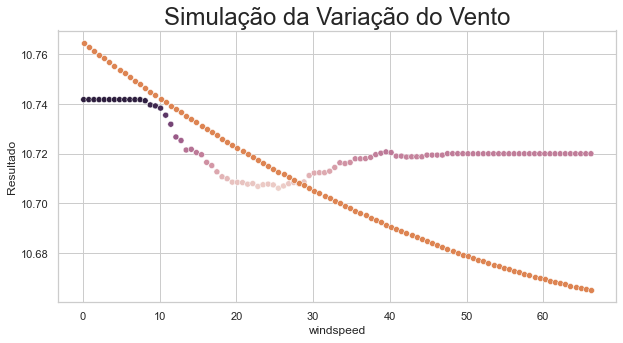

In [132]:
df_win['result_cat'] = cat_fit.predict(scaler.transform(df_win[Var]))
df_win['result_reg'] = reg_fit.predict(scaler.transform(df_win[Var]))



sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 2)
ax.set(ylabel="Resultado")

sns.scatterplot(data=df_win, x='windspeed', y='result_cat', hue='result_cat', legend = False).set(title='Simulação da Variação do Vento')
sns.scatterplot(data=df_win, x='windspeed', y='result_reg')

A regressão linear não consegue mostrar além da relação algo mais interessante. Já a Catboost mostra que o vento entre 20 km/h e 30 km/h  são os melhores resultados. Da mesma maneira valores abaixo e acima de 40 parecem não ter na base de treinamento original

[Text(0.5, 1.0, 'Distribuição da Velocidade do Vento')]

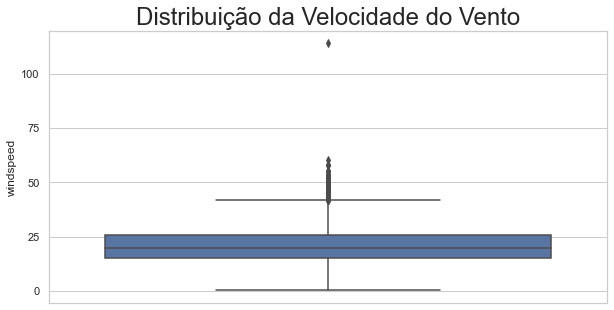

In [57]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 2)
ax.set(ylabel="Resultado")


sns.boxplot(data=df_provas_clean_man, y='windspeed').set(title='Distribuição da Velocidade do Vento')

# CONCLUSÕES 

As condições climáticas em uma prova de atletismo  de 100 metros envolve muitos outros fatores que determinam o seu resultado como o tempo de reação, a força e condicionamento fisico do atleta. Nesse estudo, de dados extraídos da organização mundial de atletismo, conseguimos prever apenas 0,5 decimos de uma prova. No entanto, é importante ressaltar que o record mundial é resolvido nos décimos. 

Logo, pode-se dizer que o modelo prever que dois atletas em iguais condições fisicas terão seus melhores resultados entre 15 e 25 graus, 60% e 80% de humidade e 


